In [51]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import calendar



Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement mplcursors (from versions: none)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for mplcursors


In [53]:
!pip install mplcursors


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement mplcursors (from versions: none)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for mplcursors


In [73]:
df = pd.read_csv("dairy_dataset.csv")  # replace with your CSV path
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

product_name = input("Enter Product Name: ").strip()
state_name = input("Enter State: ").strip()
months_ahead = int(input("Enter months to forecast (3 / 6 / 12): "))

df_product = df[
    (df['Product Name'].str.strip().str.lower() == product_name.strip().lower()) &
    (df['Location'].str.strip().str.lower() == state_name.strip().lower())
].copy()


if df_product.empty:
    print(f"The product '{product_name}' in state '{state_name}' was not found in the dataset.")
    raise ValueError("No matching data found.")
df_product['Date'] = pd.to_datetime(df_product['Date'])

# Select ONLY numeric columns BEFORE resampling
df_numeric = df_product[
    ['Date', 'Quantity Sold (liters/kg)', 'Reorder Quantity (liters/kg)']
]

df_monthly = (
    df_numeric
    .set_index('Date')
    .resample('ME')          # ✅ correct replacement for 'M'
    .mean()                  # now applied only to numeric columns
    .dropna()
)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_monthly.values)

SEQ_LENGTH = 12  # past 12 months

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=16,
    shuffle=True
)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerForecast(nn.Module):
    def __init__(self, input_size=2, d_model=128, nhead=4, num_layers=3, output_size=2):
        super().__init__()

        self.embedding = nn.Linear(input_size, d_model)
        self.positional = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=256,
            dropout=0.3,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.fc = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional(x)

        transformer_out = self.transformer(x)

        # Residual + attention focus on last token
        context = transformer_out[:, -1, :] + transformer_out.mean(dim=1)

        return self.fc(context)
        
model = TransformerForecast()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

EPOCHS = 80

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss.item():.6f}")

model.eval()

last_sequence = torch.tensor(
    scaled_data[-SEQ_LENGTH:],
    dtype=torch.float32
).unsqueeze(0)

future_predictions = []

for _ in range(months_ahead):
    with torch.no_grad():
        next_pred = model(last_sequence)
        future_predictions.append(next_pred.squeeze(0).numpy())

        last_sequence = torch.cat(
            (last_sequence[:, 1:, :], next_pred.unsqueeze(1)),
            dim=1
        )

future_predictions = scaler.inverse_transform(np.array(future_predictions))

model.eval()

last_sequence = torch.tensor(
    scaled_data[-SEQ_LENGTH:],
    dtype=torch.float32
).unsqueeze(0)

future_predictions = []

for _ in range(months_ahead):
    with torch.no_grad():
        next_pred = model(last_sequence)
        future_predictions.append(next_pred.squeeze(0).numpy())

        last_sequence = torch.cat(
            (last_sequence[:, 1:, :], next_pred.unsqueeze(1)),
            dim=1
        )

future_predictions = scaler.inverse_transform(np.array(future_predictions))

now = datetime.now()
print(f"\n{months_ahead}-Month Sales & Demand Forecast\n")

for i, pred in enumerate(future_predictions):
    month = (now.month + i - 1) % 12 + 1
    year = now.year + ((now.month + i - 1) // 12)

    print(
        f"{calendar.month_name[month]}-{year}: "
        f"Sales = {pred[0]:.2f}, Demand = {pred[1]:.2f}"
    )


Enter Product Name:  Lassi
Enter State:  kerala
Enter months to forecast (3 / 6 / 12):  3


Epoch 10/80 | Loss: 0.075290
Epoch 20/80 | Loss: 0.078719
Epoch 30/80 | Loss: 0.066315
Epoch 40/80 | Loss: 0.070880
Epoch 50/80 | Loss: 0.077109
Epoch 60/80 | Loss: 0.070736
Epoch 70/80 | Loss: 0.056803
Epoch 80/80 | Loss: 0.062698

3-Month Sales & Demand Forecast

January-2026: Sales = 183.16, Demand = 99.77
February-2026: Sales = 266.88, Demand = 117.01
March-2026: Sales = 328.16, Demand = 140.69


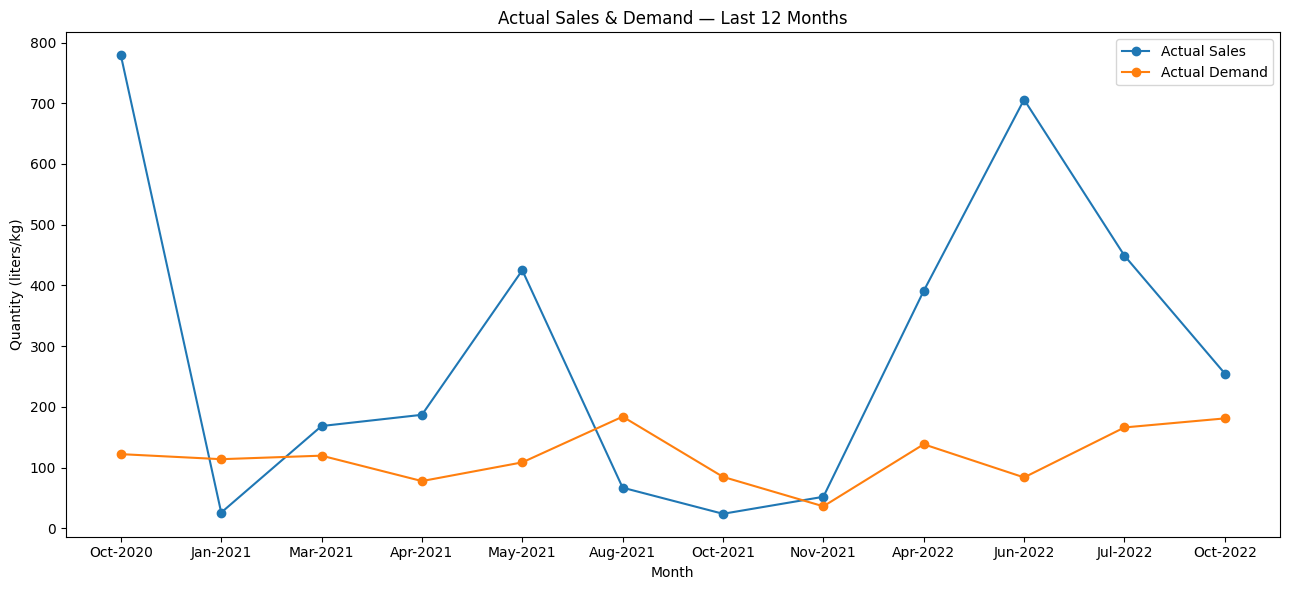

In [74]:
# import matplotlib.pyplot as plt

# # Prepare historical data
# df_hist = df_monthly.copy()

# plt.figure(figsize=(12, 6))
# plt.plot(
#     df_hist.index,
#     df_hist['Quantity Sold (liters/kg)'],
#     marker='o',
#     label='Actual Sales'
# )
# plt.plot(
#     df_hist.index,
#     df_hist['Reorder Quantity (liters/kg)'],
#     marker='o',
#     label='Actual Demand'
# )

# plt.title(f"Historical Monthly Sales & Demand for {product_name.title()}")
# plt.xlabel("Month")
# plt.ylabel("Quantity (liters/kg)")
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()import matplotlib.pyplot as plt

# Ensure sorted index
df_monthly_sorted = df_monthly.sort_index()

# Last 12 available months
df_last_12 = df_monthly_sorted.tail(12)

# Month labels
month_labels = df_last_12.index.strftime('%b-%Y')

plt.figure(figsize=(13, 6))

plt.plot(
    month_labels,
    df_last_12['Quantity Sold (liters/kg)'],
    marker='o',
    label='Actual Sales'
)

plt.plot(
    month_labels,
    df_last_12['Reorder Quantity (liters/kg)'],
    marker='o',
    label='Actual Demand'
)

plt.title("Actual Sales & Demand — Last 12 Months")
plt.xlabel("Month")
plt.ylabel("Quantity (liters/kg)")
plt.legend()
plt.tight_layout()
plt.show()


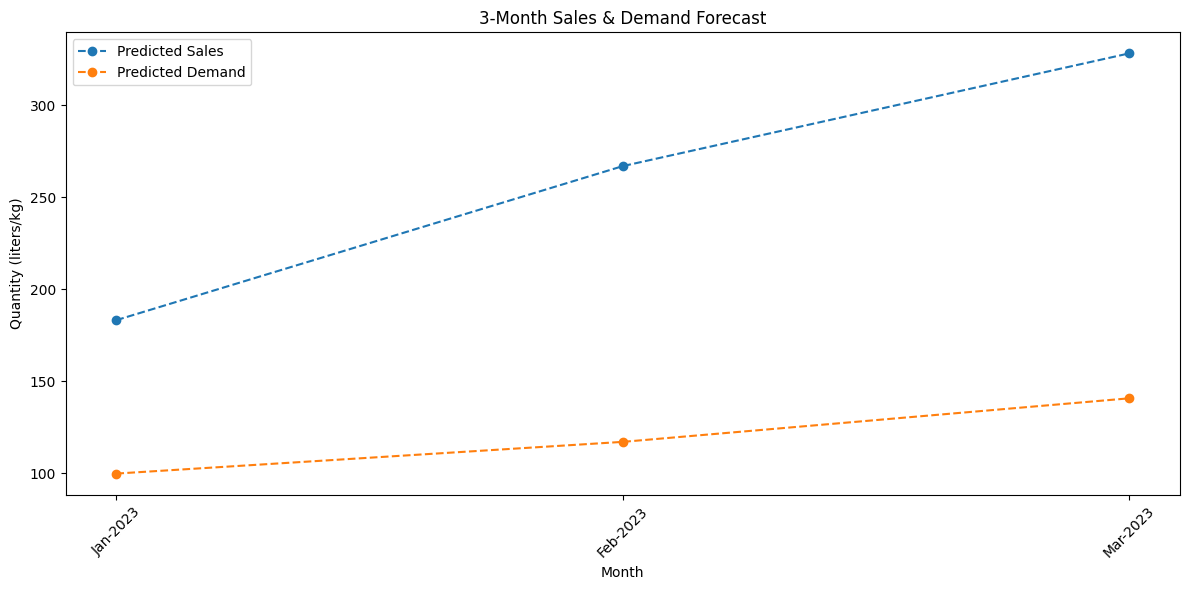

In [75]:
import matplotlib.pyplot as plt  # <-- import on its own line

# Convert future dates to Month-Year labels
month_labels = [d.strftime('%b-%Y') for d in future_dates]

plt.figure(figsize=(12, 6))

plt.plot(
    month_labels,
    future_predictions[:months_ahead, 0],
    marker='o',
    linestyle='--',
    label='Predicted Sales'
)

plt.plot(
    month_labels,
    future_predictions[:months_ahead, 1],
    marker='o',
    linestyle='--',
    label='Predicted Demand'
)

plt.title(f"{months_ahead}-Month Sales & Demand Forecast")
plt.xlabel("Month")
plt.ylabel("Quantity (liters/kg)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
